##**Libraries**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_files
import nltk
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split  
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_selection import mutual_info_classif
import time
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, precision_recall_curve, auc, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import PredefinedSplit

##**Preprocessing**

Loading the review-files and their assigned class, 0 for negative and 1 for positive

In [ ]:
!wget http://www.cs.cornell.edu/people/pabo/movie-review-data/mix20_rand700_tokens_0211.tar
!tar xvzf mix20_rand700_tokens_0211.tar

movies = load_files(container_path="tokens") 
x, y = movies.data, movies.target

In [ ]:
# First sample and target
print('Sample: {} \nTarget: {}'.format(x[1], y[1]))   # 1 positive, 0 negative

Sample: b'cast : russell crowe , joaquin phoenix , connie nielsen , oliver reed , derek jacobi , djimon hounsou , richard harris , spencer treat clark written by : david h . franzoni , john logan and william nicholson directed by : ridley scott running time : 157 minutes roman emperor marcus aurelius ( richard harris ) chooses his trusted general maximus ( russell crowe ) as his successor . however the emperor\'s evil son commodus ( joaquin phoenix ) murders his father before the announcement can be made , and maximus ( as well as his family ) is sentenced to be executed . maximus is able to escape his executioners , but is later captured and sold as a slave to proximo ( oliver reed ) . proximo is looking for gladiators to earn himself money ( he being a former gladiator himself ) , and maximus reluctantly uses his skills to prove himself a powerful gladiator . when emperor commodus announces that new games will be held in the colisseum , proximo takes his gladiators there to do battle

Removing unnecessary characters from the data

In [ ]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

docs = []

for doc in x: 
    
    # Remove non-word (special) characters such as punctuation, numbers etc
    document = re.sub(r'\W', ' ', str(doc))              # \W matches any single letter, number or underscore

    document = re.sub(r'[0-9]',' ', document)

    # Remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)  # unnecessary
      
    # Substitute multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I) # \s+ means a string of whitespace characters

    # Remove all numbers
    #document = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", document)

    # Convert to Lowercase
    document = document.lower()

    # Split the document based on whitespaces (--> List of words)
    document = document.split()
    
    # Lemmatization
    document = [lemmatizer.lemmatize(word) for word in document]
    
    # Reconstruct the document by joining the words on each whitespace
    document = ' '.join(document)

    # Append all documents into a list 'docs'
    docs.append(document)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Average document length

In [ ]:
lengths = []
for document in docs:
  lengths.append(len(document))
print(f"The average document length is {int(np.mean(lengths))} characters.")

The average document length is 3562 characters.


Average document length per class

In [ ]:
lengths_negative = []
lengths_positive = []
for i in range(len(docs)):
  if y[i] == 0:
      lengths_negative.append(len(docs[i]))
  else:
      lengths_positive.append(len(docs[i]))
print(f"The average document length for the negative class is {int(np.mean(lengths_negative))} characters.")
print(f"The average document length for the negative class is {int(np.mean(lengths_positive))} characters.")
print(f"The minimum document length for the negative class is {int(min(lengths_negative))} characters.")
print(f"The minimum document length for the negative class is {int(min(lengths_positive))} characters.")
print(f"The max document length for the negative class is {int(max(lengths_negative))} characters.")
print(f"The max document length for the negative class is {int(max(lengths_positive))} characters.")

The average document length for the negative class is 3348 characters.
The average document length for the negative class is 3774 characters.
The minimum document length for the negative class is 382 characters.
The minimum document length for the negative class is 478 characters.
The max document length for the negative class is 10111 characters.
The max document length for the negative class is 9921 characters.


In [ ]:
nltk.download('punkt')
import nltk
from nltk.tokenize import word_tokenize
tokenized_sents = [word_tokenize(i) for i in docs]
tokenized_sents = [item for sublist in tokenized_sents for item in sublist]
print("The vocabulary consists of",str(len(np.unique(tokenized_sents)))+".")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
The vocabulary consists of 30797.


Train Dev Test split

In [ ]:
# indices = np.array(range(len(docs)))
x_train, x_test, y_train, y_test = train_test_split(docs, y, test_size=0.2, random_state=13579)
# train_indices, test_indices, y_train_to_ignore, y_test_to_ignore = train_test_split(indices, y, test_size=0.2, random_state=13579)

x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.25, random_state=13579)
# train_indices, dev_indices, y_train, y_dev = train_test_split(train_indices, y_train_to_ignore, test_size=0.25, random_state=13579)

Class Balance

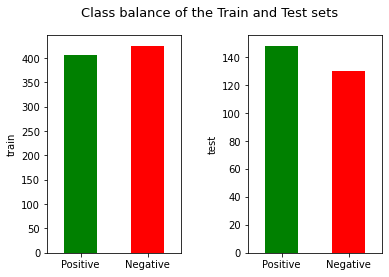

In [ ]:
ytrain_lab=pd.Series(y_train).replace({0:"Negative",1:"Positive"})
ytest_lab=pd.Series(y_test).replace({0:"Negative",1:"Positive"})

fig, axs = plt.subplots(1, 2)
_ = ytrain_lab.value_counts(ascending=True).plot(kind="bar", color=["g", "r"], ylabel="train", ax=axs[0],rot=0)
_ = ytest_lab.value_counts(sort=False).plot(kind="bar", color=["g", "r"], ylabel="test", ax=axs[1],rot=0)
fig.suptitle("Class balance of the Train and Test sets", fontsize = 13)
plt.subplots_adjust(wspace=0.5)
fig.show()

In [ ]:
# Exclude stopwords
nltk.download('stopwords')

# Use unigram & bi-gram tf*idf features
vectorizer = TfidfVectorizer(ngram_range = (1, 2), max_features = 5000, sublinear_tf = True, stop_words = stopwords.words('english'))

# Transform on all data (train - test)
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)
x_dev_tfidf = vectorizer.transform(x_dev)

print(vectorizer.get_feature_names())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['abandon', 'abandoned', 'ability', 'able', 'absent', 'absolute', 'absolutely', 'absurd', 'abuse', 'abyss', 'academy', 'academy award', 'accent', 'accept', 'acceptable', 'accident', 'accidentally', 'acclaimed', 'accomplished', 'according', 'account', 'accurate', 'accused', 'achieve', 'achievement', 'acid', 'across', 'act', 'acted', 'acting', 'acting ability', 'action', 'action comedy', 'action film', 'action hero', 'action movie', 'action scene', 'action sequence', 'action star', 'action thriller', 'activity', 'actor', 'actress', 'actual', 'actually', 'ad', 'adam', 'adam sandler', 'adaptation', 'adapted', 'add', 'added', 'adding', 'addition', 'address', 'admire', 'admit', 'admittedly', 'adult', 'advance', 'advanced', 'advantage', 'adventure', 'advice', 'affair', 'affected', 'affection', 'affleck', 'aforementioned', 'afraid', 'africa', 'african', 'african american', 'afterwards

Reducing the dimensionality of the problem, in order to visualize the data.

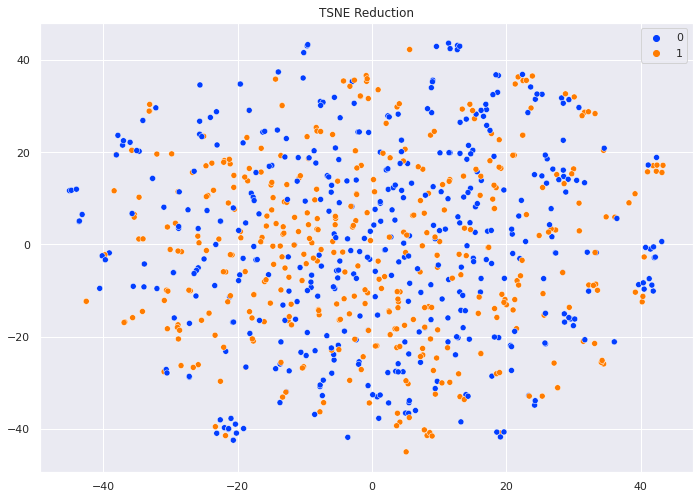

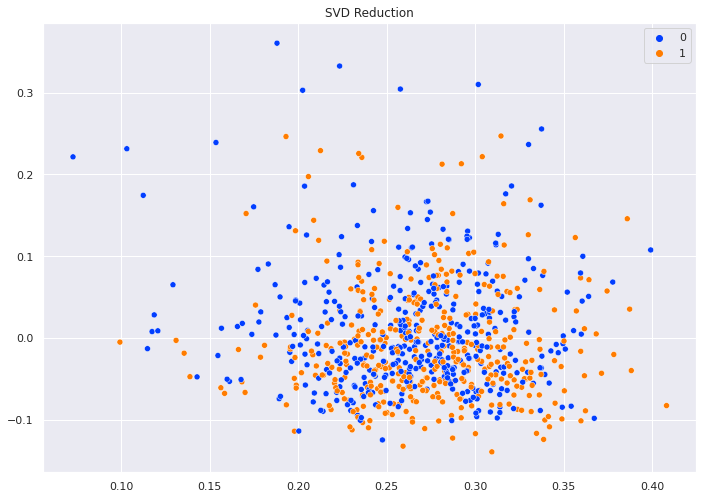

In [ ]:
# However, inference cannot be made, since the dipiction of the data would prove more useful after the parameter hyper-tuning.
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)

# Dimensionality reduction using TSNE
tsne = TSNE(n_components=2, random_state=4321)
x_train_trunc = tsne.fit_transform(x_train_tfidf)

plt.figure()
plt.title('TSNE Reduction')
sns.scatterplot(x_train_trunc[:,0], x_train_trunc[:,1], hue=y_train, legend='full', palette=palette)

# Dimensionality Reduction using SVD
svd = TruncatedSVD(n_components=2, random_state=4321)
x_train_trunc = svd.fit_transform(x_train_tfidf)

plt.figure()
plt.title('SVD Reduction')
sns.scatterplot(x_train_trunc[:,0], x_train_trunc[:,1], hue=y_train, legend='full', palette=palette)

Feauture Selection

In [ ]:
# Number of features to keep
k = 100

# Convert sparse matrix to np.array --> Slow
x_train_tfidf_array = x_train_tfidf.toarray()

# The function relies on nonparametric methods 
# based on entropy estimation from k-nearest neighbors distances
mutual_information = mutual_info_classif(x_train_tfidf_array, y_train, n_neighbors=3, discrete_features=True, random_state=4321)

# Indexes of the feature columns
indexes = np.arange(len(mutual_information))

# Sort by mutual information values --> (value, idx)
sorted_indexes = sorted(zip(mutual_information, indexes), reverse=True)   # descending
print('Sorted indexes: {}'.format(sorted_indexes[:4]))

# keep the indexes of the best k features
best_idxs = [idx for val, idx in sorted_indexes[:k]]                      # it keeps the 100 features(tokens) that have the highest dependency between the variables
print('Best indexes: {}\n'.format(best_idxs[:4]))                         # the more the features(tokens), the more possible it is to overfit the model to the data

# Keep only the colums of the best features
x_train_best_tfidf = x_train_tfidf_array[:, best_idxs]
x_test_best_tfidf = x_test_tfidf[:, best_idxs]

print('Shape of training data: {} --> {}'.format(x_train_tfidf.shape, x_train_best_tfidf.shape))
print('Shape of test data: {} --> {}\n'.format(x_test_tfidf.shape, x_test_best_tfidf.shape))

Sorted indexes: [(0.6199221022235273, 1565), (0.6112868731791328, 3138), (0.593752874118881, 2911), (0.5551857612258858, 1933)]
Best indexes: [1565, 3138, 2911, 1933]

Shape of training data: (831, 5000) --> (831, 100)
Shape of test data: (278, 5000) --> (278, 100)



##**Dummy Classifier** to set a baseline

Baseline
Training took: 0.0010561943054199219 seconds 

Train accuracy: 51.14%
Dev accuracy: 49.46% 
Test accuracy: 46.76% 

#Class 0 in Train dataset: (425,)
#Class 1 in Train dataset: (406,)

Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       425
           1       0.00      0.00      0.00       406

    accuracy                           0.51       831
   macro avg       0.26      0.50      0.34       831
weighted avg       0.26      0.51      0.35       831


Precision Recall AUC score for the negative class(train set):
0.7557160048134777

Precision Recall AUC score for the positive class(train set):
0.7442839951865223

Macro-averaged Precision Recall AUC score for the train set:
0.75

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       137
           1       0.00      0

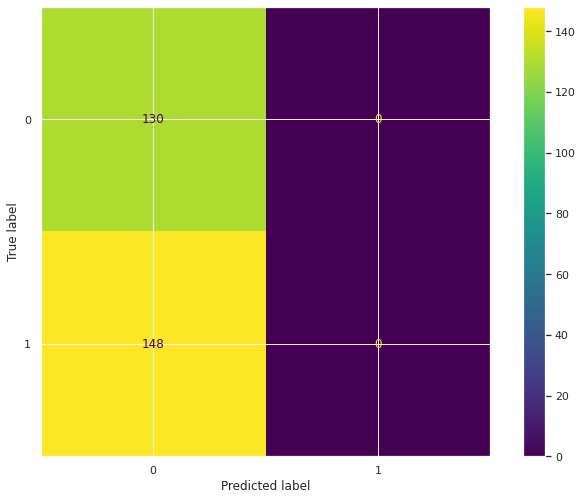

In [ ]:
# Train

# The dummy classifier always predicts the 'most frequent' class
baseline = DummyClassifier(strategy='most_frequent')
start_time = time.time()
baseline.fit(x_train_tfidf, y_train)
print("Baseline")
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate
predictions = baseline.predict(x_train_tfidf)
score = accuracy_score(y_train, predictions)
pred_train = baseline.predict_proba(x_train_tfidf)
print("Train accuracy: {:.2f}%".format(score*100))

predictions_dev = baseline.predict(x_dev_tfidf)
score = accuracy_score(y_dev, predictions_dev)
pred_dev = baseline.predict_proba(x_dev_tfidf)
print("Dev accuracy: {:.2f}% ".format(score*100))

predictions_test = baseline.predict(x_test_tfidf)
score = accuracy_score(y_test, predictions_test)
pred_test = baseline.predict_proba(x_test_tfidf)
print("Test accuracy: {:.2f}% \n".format(score*100))

print('#Class 0 in Train dataset:', np.where(y_train == 0)[0].shape)
print('#Class 1 in Train dataset:', np.where(y_train == 1)[0].shape)

#Train Set
print("\nPrecision, recall, F1 scores for each class(train set)")
print(classification_report(y_train, predictions,labels=np.array([0,1])))
print("\nPrecision Recall AUC score for the negative class(train set):")
precision, recall, thresholds = precision_recall_curve(y_train, pred_train[:,0],pos_label=0)
area_train_1 = auc(recall, precision)
print(area_train_1)
print("\nPrecision Recall AUC score for the positive class(train set):")
precision, recall, thresholds = precision_recall_curve(y_train, pred_train[:,1],pos_label=1)
area_train_2 = auc(recall, precision)
print(area_train_2)
print("\nMacro-averaged Precision Recall AUC score for the train set:")
print((area_train_1+area_train_2)/2)
#Dev Set
print("\nPrecision, recall, F1 scores for each class(dev set)")
print(classification_report(y_dev, predictions_dev,labels=np.array([0,1])))
print("\nPrecision Recall AUC score for the negative class(dev set):")
precision, recall, thresholds = precision_recall_curve(y_dev, pred_dev[:,0],pos_label=0)
area_train_1 = auc(recall, precision)
print(area_train_1)
print("\nPrecision Recall AUC score for the positive class(dev set):")
precision, recall, thresholds = precision_recall_curve(y_dev, pred_dev[:,1],pos_label=1)
area_train_2 = auc(recall, precision)
print(area_train_2)
print("\nMacro-averaged Precision Recall AUC score for the dev set:")
print((area_train_1+area_train_2)/2)
#Test Set
print("\nPrecision, recall, F1 scores for each class(test set)")
print(classification_report(y_test, predictions_test,labels=np.array([0,1])))
print("\nPrecision Recall AUC score for the negative class (test set):")
precision, recall, thresholds = precision_recall_curve(y_test, pred_test[:,0],pos_label=0)
area_train_1 = auc(recall, precision)
print(area_train_1)
print("\nPrecision Recall AUC score for the positive class (test set):")
precision, recall, thresholds = precision_recall_curve(y_test, pred_test[:,1],pos_label=1)
area_train_2 = auc(recall, precision)
print(area_train_2)
print("\nMacro-averaged Precision Recall AUC score for the test set:")
print((area_train_1+area_train_2)/2)


print("\nConfusion Matrix for test data:")
plot_confusion_matrix(estimator=baseline, X=x_test_tfidf, y_true=y_test, values_format = '.0f')

The baseline is set to 32% macro-averaged F1 score, alternatively to 46.76% accuracy.

##**Learning curves**

**Learning Curves WITHOUT cross-validation BUT with PREDEFINED validation set:**

In [ ]:
# LEARNING CURVES function WITHOUT cross-validation BUT WITH PREDEFINED dev_set
def plot_learning_curve(estimator, title, x_train_tfidf, x_dev_tfidf, x_test_tfidf, y_train, y_dev, y_test,   # given_train_sizes --> np.linspace(.1, 1.0, 5))
                        given_train_sizes):

  plt.figure()
  plt.title(title, fontsize=17)

  concat_train_dev_tfidf = np.concatenate((x_train_tfidf.todense(), x_dev_tfidf.todense()), axis=0)
  concat_train_dev_target = np.concatenate((y_train , y_dev), axis=0)
  test_fold = -1*np.ones(x_train_tfidf.shape[0]+x_dev_tfidf.shape[0])
  test_fold[x_train_tfidf.shape[0]:] = 0

  # if ylim is not None:
  #     plt.ylim(*ylim)

  plt.xlabel("Training examples", fontsize=15)
  plt.ylabel("Macro F1-score", fontsize=15)
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)
  plt.grid()

  train_sizes, train_scores, dev_scores = learning_curve(
          estimator, concat_train_dev_tfidf, concat_train_dev_target, cv=PredefinedSplit(test_fold), n_jobs=-1,scoring='f1_macro', train_sizes=given_train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  dev_scores_mean = np.mean(dev_scores, axis=1)

  plt.ylim(0.4,1.1)
  plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
            label="Training score")
  plt.plot(train_sizes, dev_scores_mean, 'o-', color="orange",
              label="Validation score")

  concat_train_test_tfidf = np.concatenate((x_train_tfidf.todense(), x_test_tfidf.todense()), axis=0)
  concat_train_test_target = np.concatenate((y_train , y_test), axis=0)
  test_fold = -1*np.ones(x_train_tfidf.shape[0]+x_test_tfidf.shape[0])
  test_fold[x_train_tfidf.shape[0]:] = 0

  train_sizes, train_scores, test_scores = learning_curve(
          estimator, concat_train_test_tfidf, concat_train_test_target, cv=PredefinedSplit(test_fold), n_jobs=-1,scoring='f1_macro', train_sizes=given_train_sizes)
  train_scores_mean = np.mean(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)

  plt.plot(train_sizes, test_scores_mean, 'o-', color="red",
              label="Test score")

  plt.legend(loc="lower right", fontsize=13)
  plt.show()

##**Logistic Regression**

Hyperparameter fine-tuning 

In [ ]:
#solver,C,max_iter,tol
a = [['liblinear','lbfgs','saga'],np.linspace(0.1, 1, 10),[25, 50, 100, 200, 300],[1e-4,1e-2,1e-6]]
list_of_param_combs = list(itertools.product(*a))

dict_1 = {}
# Solver -- Algorithm to use in the optimization problem.
for params in list_of_param_combs:
  #Train
  clf = LogisticRegression(solver=params[0],C=params[1],max_iter=params[2],tol=params[3])
  start_time = time.time()
  clf.fit(x_train_tfidf, y_train)

  # Evaluate
  predictions = clf.predict(x_dev_tfidf)
  score = f1_score(y_dev,predictions)
  dict_1[params] = score

for k in sorted(dict_1, key=dict_1.get, reverse=True):
  print(k, dict_1[k])

Learning Curve of Logistic Regression based on hyperparameter fine-tuning



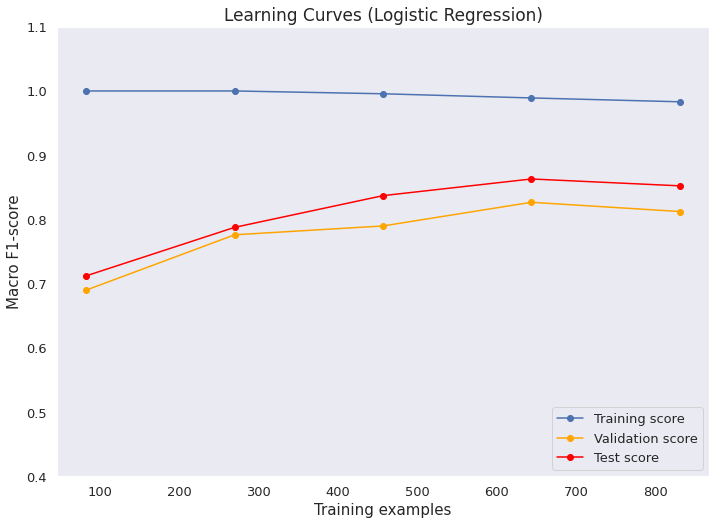

In [ ]:
plot_learning_curve(LogisticRegression(solver='liblinear',C=1,max_iter=25,tol=0.01),
                    "Learning Curves (Logistic Regression)", x_train_tfidf, x_dev_tfidf, x_test_tfidf, y_train, y_dev, y_test,   # given_train_sizes --> np.linspace(.1, 1.0, 5))
                        np.linspace(.1, 1.0, 5))

Fit based on hyperparameter fine-tuning

Logistic Regression
Training took: 0.011894464492797852 seconds 

Train accuracy: 98.32%
Dev accuracy: 81.23% 
Test accuracy: 85.25% 


Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       425
           1       0.99      0.98      0.98       406

    accuracy                           0.98       831
   macro avg       0.98      0.98      0.98       831
weighted avg       0.98      0.98      0.98       831


Precision Recall AUC score for the negative class(train set):
0.9992836601541197

Precision Recall AUC score for the positive class(train set):
0.9991924023791916

Macro-averaged Precision Recall AUC score for the train set:
0.9992380312666557

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       137
           1       0.82      0.81      0.81       140

    accuracy       

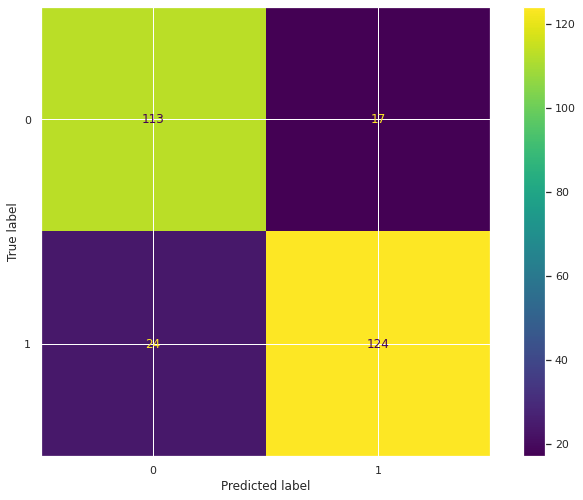

In [ ]:
# Train

# Solver -- Algorithm to use in the optimization problem.
clf = LogisticRegression(solver="liblinear", C=1, max_iter=100, tol=0.0001)
start_time = time.time()
clf.fit(x_train_tfidf, y_train)

print("Logistic Regression")
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate
predictions = clf.predict(x_train_tfidf)
score = accuracy_score(y_train, predictions)
pred_train = clf.predict_proba(x_train_tfidf)
# model.predict() returns outputs of 0 or 1
# model.predict_proba() returns an array: [P(x=0), P(x=1)]
print("Train accuracy: {:.2f}%".format(score*100))

predictions_dev = clf.predict(x_dev_tfidf)
score = accuracy_score(y_dev, predictions_dev)
pred_dev = clf.predict_proba(x_dev_tfidf)
print("Dev accuracy: {:.2f}% ".format(score*100))

predictions_test = clf.predict(x_test_tfidf)
score = accuracy_score(y_test, predictions_test)
pred_test = clf.predict_proba(x_test_tfidf)
print("Test accuracy: {:.2f}% \n".format(score*100))

#Train Set
print("\nPrecision, recall, F1 scores for each class(train set)")
print(classification_report(y_train, predictions,labels=np.array([0,1])))
print("\nPrecision Recall AUC score for the negative class(train set):")
precision, recall, thresholds = precision_recall_curve(y_train, pred_train[:,0],pos_label=0)
area_train_1 = auc(recall, precision)
print(area_train_1)
print("\nPrecision Recall AUC score for the positive class(train set):")
precision, recall, thresholds = precision_recall_curve(y_train, pred_train[:,1],pos_label=1)
area_train_2 = auc(recall, precision)
print(area_train_2)
print("\nMacro-averaged Precision Recall AUC score for the train set:")
print((area_train_1+area_train_2)/2)
#Dev Set
print("\nPrecision, recall, F1 scores for each class(dev set)")
print(classification_report(y_dev, predictions_dev,labels=np.array([0,1])))
print("\nPrecision Recall AUC score for the negative class(dev set):")
precision, recall, thresholds = precision_recall_curve(y_dev, pred_dev[:,0],pos_label=0)
area_train_1 = auc(recall, precision)
print(area_train_1)
print("\nPrecision Recall AUC score for the positive class(dev set):")
precision, recall, thresholds = precision_recall_curve(y_dev, pred_dev[:,1],pos_label=1)
area_train_2 = auc(recall, precision)
print(area_train_2)
print("\nMacro-averaged Precision Recall AUC score for the dev set:")
print((area_train_1+area_train_2)/2)
#Test Set
print("\nPrecision, recall, F1 scores for each class(test set)")
print(classification_report(y_test, predictions_test,labels=np.array([0,1])))
print("\nPrecision Recall AUC score for the negative class (test set):")
precision, recall, thresholds = precision_recall_curve(y_test, pred_test[:,0],pos_label=0)
area_train_1 = auc(recall, precision)
print(area_train_1)
print("\nPrecision Recall AUC score for the positive class (test set):")
precision, recall, thresholds = precision_recall_curve(y_test, pred_test[:,1],pos_label=1)
area_train_2 = auc(recall, precision)
print(area_train_2)
print("\nMacro-averaged Precision Recall AUC score for the test set:")
print((area_train_1+area_train_2)/2)

print("\nConfusion Matrix for test data:")
plot_confusion_matrix(estimator=clf, X=x_test_tfidf, y_true=y_test, values_format = '.0f')

##**k-Nearest Neighbors**

Hyperparameter fine-tuning 

In [ ]:
#n_neighbors,  weights, algorithm)
a = [np.linspace(5, 60, 56),['uniform','distance'],['auto', 'ball_tree', 'kd_tree', 'brute']]
list_of_param_combs = list(itertools.product(*a))

dict_2 = {}
for params in list_of_param_combs:
  # Train
  clf = KNeighborsClassifier(n_neighbors=int(params[0]),weights=params[1],algorithm=params[2])
  clf.fit(x_train_tfidf, y_train)

  # Evaluate
  predictions = clf.predict(x_dev_tfidf)
  predictions_train=clf.predict(x_train_tfidf)
  score = f1_score(y_dev,predictions)
  score_train = f1_score(y_train,predictions_train)
  if abs(score_train-score)<0.05:
    dict_2[params]=score

for k in sorted(dict_2, key=dict_2.get, reverse=True):
  print(k, dict_2[k]) 

(54.0, 'uniform', 'auto') 0.7702702702702704
(54.0, 'uniform', 'ball_tree') 0.7702702702702704
(54.0, 'uniform', 'kd_tree') 0.7702702702702704
(54.0, 'uniform', 'brute') 0.7702702702702704
(58.0, 'uniform', 'auto') 0.7666666666666666
(58.0, 'uniform', 'ball_tree') 0.7666666666666666
(58.0, 'uniform', 'kd_tree') 0.7666666666666666
(58.0, 'uniform', 'brute') 0.7666666666666666
(52.0, 'uniform', 'auto') 0.7651006711409395
(52.0, 'uniform', 'ball_tree') 0.7651006711409395
(52.0, 'uniform', 'kd_tree') 0.7651006711409395
(52.0, 'uniform', 'brute') 0.7651006711409395
(53.0, 'uniform', 'auto') 0.7631578947368421
(53.0, 'uniform', 'ball_tree') 0.7631578947368421
(53.0, 'uniform', 'kd_tree') 0.7631578947368421
(53.0, 'uniform', 'brute') 0.7631578947368421
(56.0, 'uniform', 'auto') 0.760942760942761
(56.0, 'uniform', 'ball_tree') 0.760942760942761
(56.0, 'uniform', 'kd_tree') 0.760942760942761
(56.0, 'uniform', 'brute') 0.760942760942761
(57.0, 'uniform', 'auto') 0.7597402597402598
(57.0, 'unifor

Learning Curve of KNN based on hyperparameter fine-tuning

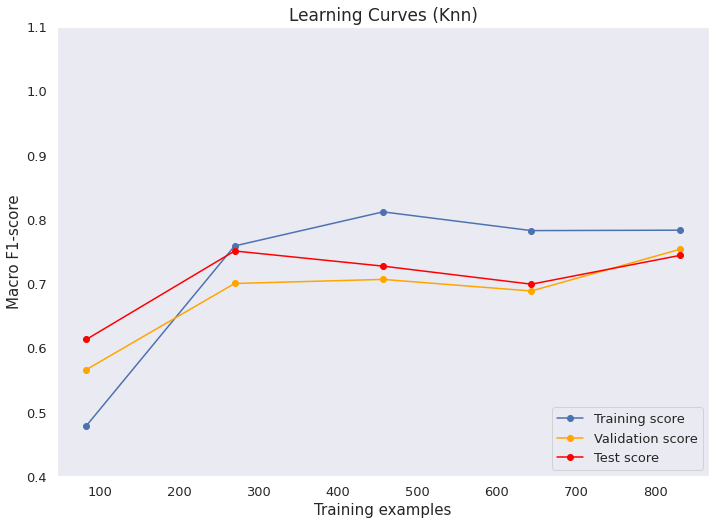

In [ ]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=54,weights='uniform',algorithm='auto'),
                    "Learning Curves (Knn)", x_train_tfidf, x_dev_tfidf, x_test_tfidf, y_train, y_dev, y_test,   # given_train_sizes --> np.linspace(.1, 1.0, 5))
                        np.linspace(.1, 1.0, 5))

Fit based on hyperparameter fine-tuning

k-Nearest Neighbors
Training took: 0.002455472946166992 seconds 

Train accuracy: 78.34%
Dev accuracy: 75.45% 
Test accuracy: 74.82% 


Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       425
           1       0.75      0.83      0.79       406

    accuracy                           0.78       831
   macro avg       0.79      0.78      0.78       831
weighted avg       0.79      0.78      0.78       831


Precision Recall AUC score for the negative class(train set):
0.8694623147183104

Precision Recall AUC score for the positive class(train set):
0.8633811325207927

Macro-averaged Precision Recall AUC score for the train set:
0.8664217236195515

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

           0       0.79      0.69      0.74       137
           1       0.73      0.81      0.77       140

    accuracy       

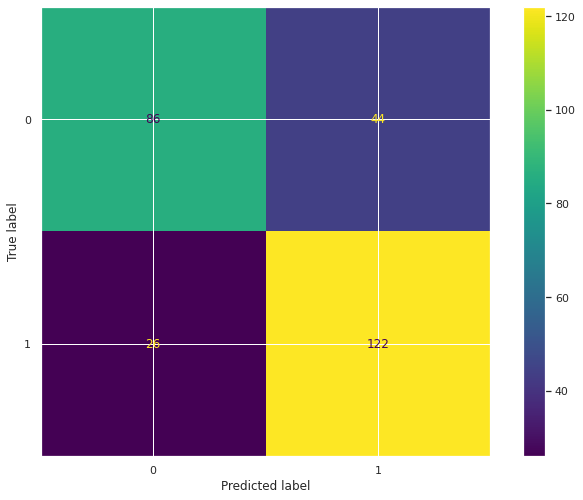

In [ ]:
# Train
clf = KNeighborsClassifier(n_neighbors=54,weights='uniform',algorithm='auto')
start_time = time.time()
clf.fit(x_train_tfidf, y_train)
print("k-Nearest Neighbors")
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate
predictions = clf.predict(x_train_tfidf)
score = accuracy_score(y_train, predictions)
pred_train = clf.predict_proba(x_train_tfidf)
print("Train accuracy: {:.2f}%".format(score*100))

predictions_dev = clf.predict(x_dev_tfidf)
score = accuracy_score(y_dev, predictions_dev)
pred_dev = clf.predict_proba(x_dev_tfidf)
print("Dev accuracy: {:.2f}% ".format(score*100))

predictions_test = clf.predict(x_test_tfidf)
score = accuracy_score(y_test, predictions_test)
pred_test = clf.predict_proba(x_test_tfidf)
print("Test accuracy: {:.2f}% \n".format(score*100))

#Train Set
print("\nPrecision, recall, F1 scores for each class(train set)")
print(classification_report(y_train, predictions,labels=np.array([0,1])))
print("\nPrecision Recall AUC score for the negative class(train set):")
precision, recall, thresholds = precision_recall_curve(y_train, pred_train[:,0],pos_label=0)
area_train_1 = auc(recall, precision)
print(area_train_1)
print("\nPrecision Recall AUC score for the positive class(train set):")
precision, recall, thresholds = precision_recall_curve(y_train, pred_train[:,1],pos_label=1)
area_train_2 = auc(recall, precision)
print(area_train_2)
print("\nMacro-averaged Precision Recall AUC score for the train set:")
print((area_train_1+area_train_2)/2)
#Dev Set
print("\nPrecision, recall, F1 scores for each class(dev set)")
print(classification_report(y_dev, predictions_dev,labels=np.array([0,1])))
print("\nPrecision Recall AUC score for the negative class(dev set):")
precision, recall, thresholds = precision_recall_curve(y_dev, pred_dev[:,0],pos_label=0)
area_train_1 = auc(recall, precision)
print(area_train_1)
print("\nPrecision Recall AUC score for the positive class(dev set):")
precision, recall, thresholds = precision_recall_curve(y_dev, pred_dev[:,1],pos_label=1)
area_train_2 = auc(recall, precision)
print(area_train_2)
print("\nMacro-averaged Precision Recall AUC score for the dev set:")
print((area_train_1+area_train_2)/2)
#Test Set
print("\nPrecision, recall, F1 scores for each class(test set)")
print(classification_report(y_test, predictions_test,labels=np.array([0,1])))
print("\nPrecision Recall AUC score for the negative class (test set):")
precision, recall, thresholds = precision_recall_curve(y_test, pred_test[:,0],pos_label=0)
area_train_1 = auc(recall, precision)
print(area_train_1)
print("\nPrecision Recall AUC score for the positive class (test set):")
precision, recall, thresholds = precision_recall_curve(y_test, pred_test[:,1],pos_label=1)
area_train_2 = auc(recall, precision)
print(area_train_2)
print("\nMacro-averaged Precision Recall AUC score for the test set:")
print((area_train_1+area_train_2)/2)

print("\nConfusion Matrix for test data:")
plot_confusion_matrix(estimator=clf, X=x_test_tfidf, y_true=y_test, values_format = '.0f')

##**Naive Bayes**

Hyperparameter fine-tuning

In [ ]:
# reg_param, store_covariance, tol
a = [np.linspace(0,5,50)]
list_of_param_combs = list(itertools.product(*a))
dict_3={}
for params in list_of_param_combs:
  # Train
  clf = MultinomialNB(alpha=params[0])
  clf.fit(x_train_tfidf, y_train)

  # Evaluate
  predictions = clf.predict(x_dev_tfidf)
  score = f1_score(y_dev,predictions)
  dict_3[params]=score

for k in sorted(dict_3, key=dict_3.get, reverse=True):
  print(k, dict_3[k])

(0.20408163265306123,) 0.8044280442804428
(0.30612244897959184,) 0.8014705882352942
(0.40816326530612246,) 0.8
(0.10204081632653061,) 0.7999999999999999
(0.5102040816326531,) 0.7910447761194029
(1.0204081632653061,) 0.7881040892193307
(0.6122448979591837,) 0.7865168539325843
(0.7142857142857143,) 0.7835820895522388
(0.8163265306122449,) 0.7835820895522388
(0.9183673469387755,) 0.7835820895522388
(1.1224489795918369,) 0.7835820895522388
(1.2244897959183674,) 0.7835820895522388
(1.5306122448979593,) 0.7832699619771863
(1.3265306122448979,) 0.7790262172284645
(1.6326530612244898,) 0.7786259541984734
(1.7346938775510203,) 0.7786259541984734
(1.4285714285714286,) 0.7773584905660378
(1.9387755102040818,) 0.7769230769230769
(2.0408163265306123,) 0.7769230769230769
(2.142857142857143,) 0.7751937984496123
(1.836734693877551,) 0.7739463601532567
(2.3469387755102042,) 0.7734375
(2.2448979591836737,) 0.7704280155642023
(2.4489795918367347,) 0.7686274509803921
(2.7551020408163267,) 0.76679841897233

Learning Curve of Naive Bayes based on hyperparameter fine-tuning

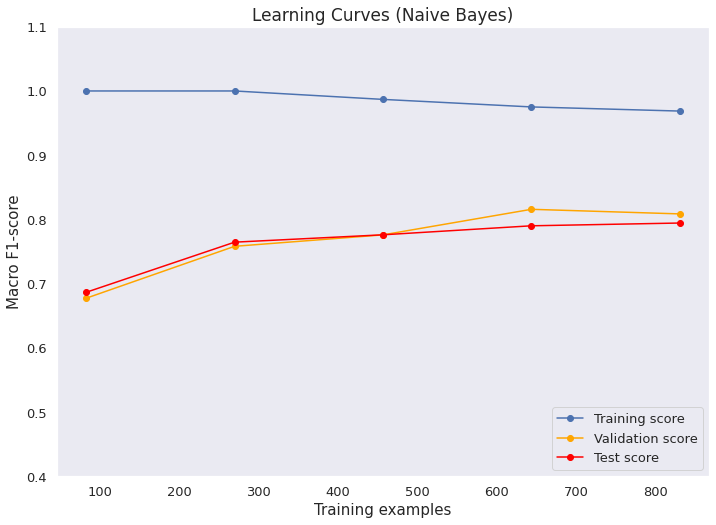

In [ ]:
plot_learning_curve(MultinomialNB(alpha=0.20408163265306123),
                    "Learning Curves (Naive Bayes)", x_train_tfidf, x_dev_tfidf, x_test_tfidf, y_train, y_dev, y_test,  # given_train_sizes --> np.linspace(.1, 1.0, 5))
                        np.linspace(.1, 1.0, 5))

Fit based on hyperparameter fine-tuning 

Naive Bayes
Training took: 0.004151105880737305 seconds 

Train accuracy: 96.87%
Dev accuracy: 80.87% 
Test accuracy: 79.50% 


Precision, recall, F1 scores for each class(train set)
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       425
           1       0.97      0.97      0.97       406

    accuracy                           0.97       831
   macro avg       0.97      0.97      0.97       831
weighted avg       0.97      0.97      0.97       831


Precision Recall AUC score for the negative class(train set):
0.9945804634389207

Precision Recall AUC score for the positive class(train set):
0.9948151067199146

Macro-averaged Precision Recall AUC score for the train set:
0.9946977850794176

Precision, recall, F1 scores for each class(dev set)
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       137
           1       0.83      0.78      0.80       140

    accuracy               

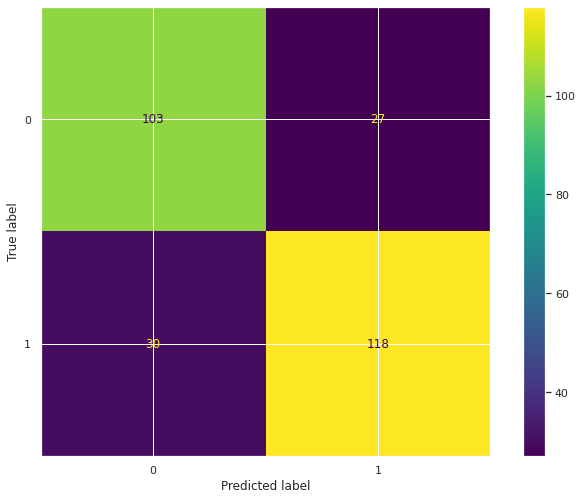

In [ ]:
# Train
clf = MultinomialNB(alpha=0.204)
start_time = time.time()
clf.fit(x_train_tfidf, y_train)
print("Naive Bayes")
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate
predictions = clf.predict(x_train_tfidf)
score = accuracy_score(y_train, predictions)
pred_train = clf.predict_proba(x_train_tfidf)
print("Train accuracy: {:.2f}%".format(score*100))

predictions_dev = clf.predict(x_dev_tfidf)
score = accuracy_score(y_dev, predictions_dev)
pred_dev = clf.predict_proba(x_dev_tfidf)
print("Dev accuracy: {:.2f}% ".format(score*100))

predictions_test = clf.predict(x_test_tfidf)
score = accuracy_score(y_test, predictions_test)
pred_test = clf.predict_proba(x_test_tfidf)
print("Test accuracy: {:.2f}% \n".format(score*100))

#Train Set
print("\nPrecision, recall, F1 scores for each class(train set)")
print(classification_report(y_train, predictions,labels=np.array([0,1])))
print("\nPrecision Recall AUC score for the negative class(train set):")
precision, recall, thresholds = precision_recall_curve(y_train, pred_train[:,0],pos_label=0)
area_train_1 = auc(recall, precision)
print(area_train_1)
print("\nPrecision Recall AUC score for the positive class(train set):")
precision, recall, thresholds = precision_recall_curve(y_train, pred_train[:,1],pos_label=1)
area_train_2 = auc(recall, precision)
print(area_train_2)
print("\nMacro-averaged Precision Recall AUC score for the train set:")
print((area_train_1+area_train_2)/2)
#Dev Set
print("\nPrecision, recall, F1 scores for each class(dev set)")
print(classification_report(y_dev, predictions_dev,labels=np.array([0,1])))
print("\nPrecision Recall AUC score for the negative class(dev set):")
precision, recall, thresholds = precision_recall_curve(y_dev, pred_dev[:,0],pos_label=0)
area_train_1 = auc(recall, precision)
print(area_train_1)
print("\nPrecision Recall AUC score for the positive class(dev set):")
precision, recall, thresholds = precision_recall_curve(y_dev, pred_dev[:,1],pos_label=1)
area_train_2 = auc(recall, precision)
print(area_train_2)
print("\nMacro-averaged Precision Recall AUC score for the dev set:")
print((area_train_1+area_train_2)/2)
#Test Set
print("\nPrecision, recall, F1 scores for each class(test set)")
print(classification_report(y_test, predictions_test,labels=np.array([0,1])))
print("\nPrecision Recall AUC score for the negative class (test set):")
precision, recall, thresholds = precision_recall_curve(y_test, pred_test[:,0],pos_label=0)
area_train_1 = auc(recall, precision)
print(area_train_1)
print("\nPrecision Recall AUC score for the positive class (test set):")
precision, recall, thresholds = precision_recall_curve(y_test, pred_test[:,1],pos_label=1)
area_train_2 = auc(recall, precision)
print(area_train_2)
print("\nMacro-averaged Precision Recall AUC score for the test set:")
print((area_train_1+area_train_2)/2)


print("\nConfusion Matrix for test data:")
plot_confusion_matrix(estimator=clf, X=x_test_tfidf, y_true=y_test, values_format = '.0f')